In [1]:
%run ../../macro_tQ.py
import sys
sys.path.append('../../')
import macro_tQ as tQ

import numpy as np
import scipy.linalg as la
from IPython.display import display,Markdown,Latex
import matplotlib.pyplot as plt
from qiskit.tools.visualization import array_to_latex

<IPython.core.display.Latex object>

/opt/anaconda3/envs/TalentQ/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


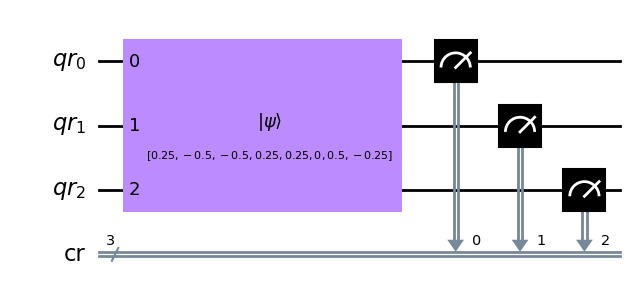

Cuentas= {'011': 6330, '111': 6205, '100': 6187, '110': 24875, '001': 25022, '000': 6221, '010': 25160}


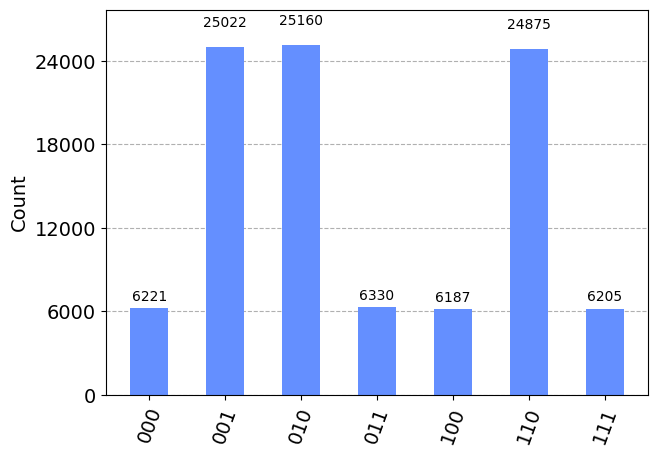

Probabilidades= {'011': 0.0633, '111': 0.06205, '100': 0.06187, '110': 0.24875, '001': 0.25022, '000': 0.06221, '010': 0.2516}


In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
import numpy.linalg as la
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator 

'definimos un estado de entrada en H^3$'
psi =[1.,-2, -2,1,1,0,2,-1]
psi/=la.norm(psi)
display(Statevector(psi).draw('Latex'))

qr = QuantumRegister(3,name='qr')
cr = ClassicalRegister(3,name='cr')
qc_psi_Qs = QuantumCircuit(qr,cr)
qc_psi_Qs.initialize(psi,qr)
qc_psi_Qs.measure(qr[:],cr[:])
display(qc_psi_Qs.draw(output='mpl'))

'ejecutamos el circuito y graficamos la estadística de cuentas'
nshots = 100000

job=AerSimulator().run(qc_psi_Qs,shots=nshots) 
result=job.result()
counts = result.get_counts()        
print('Cuentas=',counts)        #diccionario de cuentas
display(plot_histogram(counts)) # Mostramos un histograma de resultados

'transformamos las cuentas en un diccionario de  probabilidades '    
probs_psi=counts.copy()         # vamos a modificar el diccionario "cuentas" con las probabilidades 
for bitstring,counts in probs_psi.items():
    probs_psi[bitstring]= counts/nshots

print('Probabilidades=', probs_psi)

/opt/anaconda3/envs/TalentQ/lib/python3.11/site-packages/qiskit/visualization/circuit/matplotlib.py:266: FutureWarning: The default matplotlib drawer scheme will be changed to "iqp" in a following release. To silence this warning, specify the current default explicitly as style="clifford", or the new default as style="iqp".
  self._style, def_font_ratio = load_style(self._style)


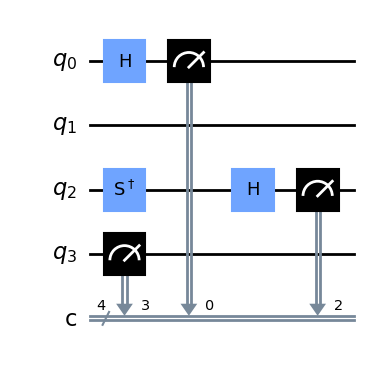

In [3]:
def add_multimeasure_XYZ(qc,paulistring):

    assert(qc.num_qubits==len(paulistring)) #check whether width of circuit coincides with length of Pauli string

    for i,basis in enumerate(reversed(paulistring)):
        if  basis == 'X':
            qc.h(i)    
            qc.measure(i, i)
        elif basis == 'Z':
            qc.measure(i, i)
            pass    
        elif basis == 'Y':
            qc.sdg(i)
            qc.h(i)
            qc.measure(i, i)

    return qc 

'Veamos un ejemplo'
from qiskit import QuantumCircuit
qc = QuantumCircuit(4,4)
add_multimeasure_XYZ(qc,'ZYIX')  # probar a cambiar el aparato de medida
qc.draw('mpl')

In [4]:
def add_Bell_measurement(qc,qubits=[0,1]):
    qc.cx(qubits[0],qubits[1])
    qc.h(0)
    qc.barrier()
    qc.measure([0,1],[1,0])
    
'ahora verificamos'
from qiskit import QuantumCircuit

'creamos el circuito'
qc = QuantumCircuit(2,2)

'definimos la base de Bell'
B00 = np.array([1,0,0,1]/np.sqrt(2))
B01 = np.array([1,0,0,-1]/np.sqrt(2))
B10 = np.array([0,1,1,0]/np.sqrt(2))
B11 = np.array([0,1,-1,0]/np.sqrt(2))

'inicializamos el estado de entrada en cualquiera de los estados anteriores'
qc.initialize(B10,[0,1])

'añadimos el medidor en la base de Bell
add_Bell_measurement(qc,[0,1])
display(qc.draw('mpl'))

execute(qc,backend=M_simulator).result().get_counts()

SyntaxError: unterminated string literal (detected at line 22) (39274172.py, line 22)

In [5]:
' Matrices de Pauli'
s0 = np.array([[1,0],[0,1]]) # matriz identidad
s1 = np.array([[0,1],[1,0]])
s2 = np.array([[0,-1j],[1j,0]])
s3 = np.array([[1,0],[0,-1]])

Pauli_basis = [s0,s1,s2,s3]

' Cadena de Pauli YIZ = s2s0s3' 
Pauli_string_203 = np.kron(s2,np.kron(s0,s3))
display(array_to_latex(Pauli_string_203,prefix='YIZ ='))

'Matriz arbitraria'
A = np.random.rand(8,8) + 1j* np.random.rand(8,8)

'Proyección a_203 de A sobre YIZ'
a_203 = np.trace(np.dot(A,Pauli_string_203))/2**3

print('a_203 = ', a_203)

<IPython.core.display.Latex object>

a_203 =  (0.04860666087768152-0.10566882109907273j)


In [6]:
'aprovechamos el diccionatio "probs_psi" creado al principio de este capítulo'

mean = 0
for bitstring,probs  in probs_psi.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * probs 

print('<ZZZ>_shots =', np.round(mean,5) )

'verificamos con la expresión analítica'
Z = np.array([[1,0],[0,-1]])
ZZZ = np.kron(s3,np.kron(s3,s3))
print('<ZZZ>_analitico =', tQ.braket(psi,np.dot(ZZZ,psi)) )

variance=0
for bitstring,probs  in probs_psi.items():
    variance += ((-1)**(sum([int(bit) for bit in bitstring]))-mean)**2 * probs
    
print('sigma = ', np.sqrt(variance) )

<ZZZ>_shots = -0.25148
<ZZZ>_analitico = -0.25
sigma =  0.9678624951923698


In [7]:
qr = QuantumRegister(3)
cr = ClassicalRegister(3)
qc = QuantumCircuit(qr,cr)


' ahora generamos el circuito que mide en la base ZXY'
qc.initialize(psi, qr)
add_multimeasure_XYZ(qc,'ZXY')
qc.draw(output='mpl')

counts = AerSimulator().run(qc,shots=nshots).result().get_counts()
print(counts)

mean = 0
for bitstring,count  in counts.items():
    mean += (-1)**(sum([int(bit) for bit in bitstring])) * count/nshots 

print('<ZXY> =', np.round(mean,5) )

'verificamos con la expresión analítica'
ZXY = np.kron(s3,np.kron(s2,s1))
print('<ZXY>_analitico =', tQ.braket(psi,np.dot(ZXY,psi)) )


{'110': 3128, '001': 3195, '100': 15553, '111': 3087, '011': 28437, '101': 15547, '000': 3169, '010': 27884}
<ZXY> = 0.00562
<ZXY>_analitico = 0j


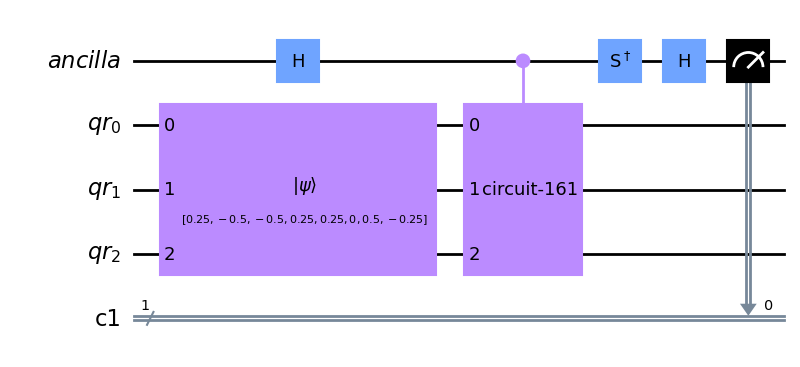

In [8]:
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister

qr = QuantumRegister(3, name = 'qr')
qra = QuantumRegister(1, name = 'ancilla')
cr = ClassicalRegister(1)

'creamos el operador como una puerta "gate" que admite el método "control'
qc0 = QuantumCircuit(qr)
qc0.z(qr)
CZZZ_gate = qc0.to_gate().control(1,ctrl_state= 1) 

'creamos el circuito con el operador controlado'
qc_Had = QuantumCircuit(qra,qr,cr)
qc_Had.initialize(psi,qr)
qc_Had.h(qra)  
qc_Had.append(CZZZ_gate,qra[:] + qr[:])
qc_Had.sdg(qra)
qc_Had.h(qra)
qc_Had.measure(qra,cr)

qc_Had.draw('mpl')

In [9]:
M_backend = Aer.get_backend('qasm_simulator')
shots=1000000

cuentas_Had= execute(qc_Had,M_backend,shots=shots).result().get_counts()
print(cuentas_Had)

from qiskit.tools.visualization import plot_histogram
plot_histogram(cuentas_Had)

NameError: name 'Aer' is not defined

In [10]:
val_esp_sigma(cuentas_Had)

NameError: name 'val_esp_sigma' is not defined